# Diabetic Rethinoplasty: Image Classification with CNN 

This Jupyter Notebook contains our solution for classifying the diabetic rethinoplasty data set using the EfficientNet architecture. 

Submitted by: 
* Lara Noe (217461)
* Hiroya Taguchi ()

## Library Imports

In [32]:
import os
import cv2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB1, EfficientNetV2B1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers, utils, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Data Preparation 

## Loading data from directory

In [33]:
train_dir = "../DR_data_cropped_classes/train/"
test_dir = "../DR_data_cropped_classes/test/"

In [34]:
batch_size = 32
img_width = img_height = 224
img_size = (img_width, img_height)
validation_split = 0.2
seed = 42
lr = 0.001

In [35]:
train_ds = utils.image_dataset_from_directory(
    train_dir, 
    validation_split = validation_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4080 files belonging to 5 classes.
Using 3264 files for training.


In [36]:
val_ds = utils.image_dataset_from_directory(
    train_dir, 
    validation_split = validation_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4080 files belonging to 5 classes.
Using 816 files for validation.


In [37]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 510 files belonging to 5 classes.


In [38]:
class_names=train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


### Some samples from the training data set

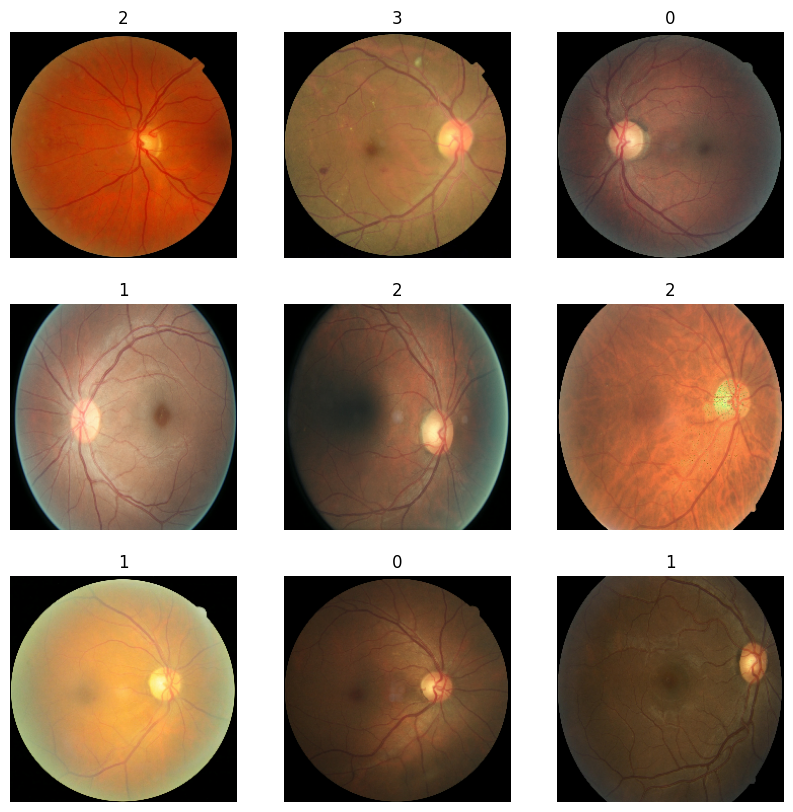

In [39]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [40]:
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define Data Augmentation

Since our dataset only contains a couple hundred images per class, we try to increase the training set by applying different data augmentation techniques. We tried to choose augmentations that resemble the actual data, to enable more generalitzation. 

* Random Flip: Horizontal to create more even distribution between "left" and "right" eye -> prevent model from viewing light spot where eye nerve enters as an important feature
* Brightness: Some images very dark, others very light
* Contrast:
* Translation: 

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomBrightness((-0.3, 0.3)),
        layers.RandomContrast(0.2),
        #layers.RandomRotation(0.1, fill_mode='constant'),
        #layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
        layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
    ]
)


### Samples of Augmented Images

2024-01-08 08:39:31.871500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:148: Filling up shuffle buffer (this may take a while): 74 of 1000
2024-01-08 08:39:34.360838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


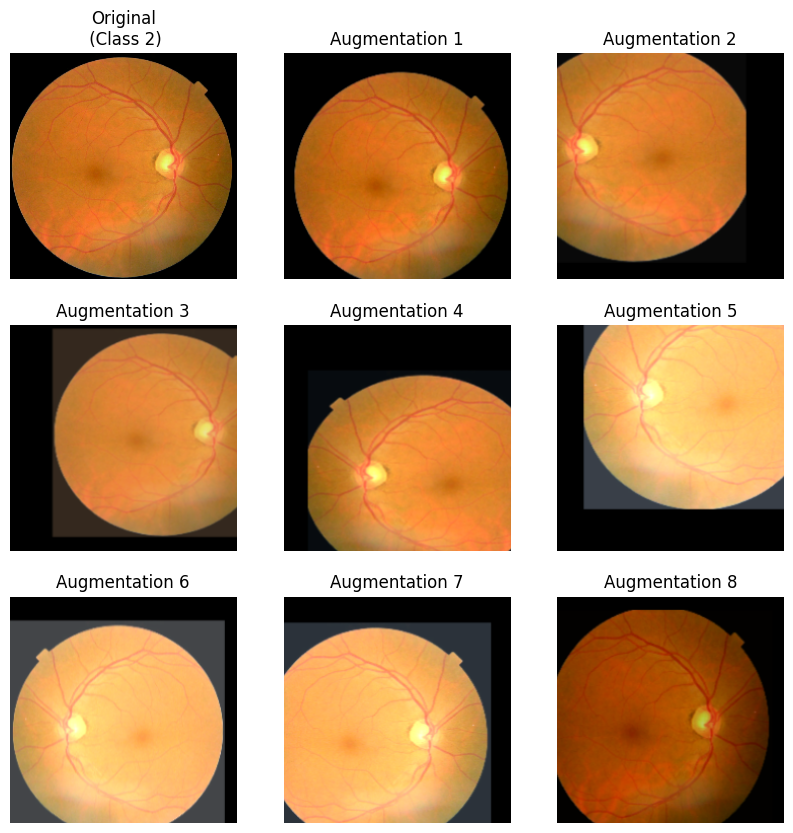

In [43]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(f"Augmentation {i}")
        plt.axis("off")

    ax = plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype("int32"))
    plt.title(f"Original\n (Class {labels[0]})")
    plt.axis("off")

# Model Preparation

## Techniques for dealing with small dataset

## Base-Model: EfficientNet

The diabetic retinipathy dataset only consists of a couple houndred samples per class, which is why we apply techniques to deal with little data. Besides using data augmentation techniques it is suggested to use a smaller model architecture, to avoid overfitting
[[Source](https://hackernoon.com/7-effective-ways-to-deal-with-a-small-dataset-2gyl407s)]. After testing different architectures, decided on the EfficientNet, since it is small but can achieve as good results as a Vision Transformer in less time.  

List of small but efficient architectures: <br>
https://towardsdatascience.com/3-small-but-powerful-convolutional-networks-27ef86faa42d

Additionally: make training faster, since we don't have access to a GPU so training bigger models very time consuming

In [44]:
input = keras.Input(shape=(*(img_size), 3))
augmented_inputs = data_augmentation(input, training=False)

base_model = EfficientNetV2B1(
    weights='imagenet', 
    include_top=False, 
    input_tensor = augmented_inputs,
    input_shape=(*(img_size), 3)
)

base_model.trainable = False

## Defining a Custom Head for the Model

In [45]:
input_layer = base_model.input

x = base_model.output
x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(5,
                      activation='softmax',
                      name='output')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output, name='TransferModelEffNet')
#model.summary()

## Compiling the Model

In [46]:
model.compile(optimizer=optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Adding Callbacks

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)

callbacks = [early_stopping, reduce_lr]

# Training the Model

As the training history shows, the training metrics improve quite slow but steady. Especially the loss values for both training and validation decrease with almost every epoch and will eventually converge, if given more time. The small model size and therefore faster inference time enables us to train for more epochs in shorter time, which leads to better overall results than with other models. We included early stopping to avoid negative effects on our model in case of overfitting.

Adjusted Hyperparameters:
* Smaller learn rate (0.001)
* Larger number of epochs to give the model time to decrease the loss as much as possible 
* Impacient learn rate reduction (after 2 epochs without improvement) to avoid plateaus
* Early stopping to avoid overfitting

In [48]:
init_time = datetime.datetime.now()
epochs = 30

history = model.fit(
    train_ds,
    epochs=epochs, 
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

required_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(required_time)}\n')

Epoch 1/30
102/102 [==============================] - 142s 1s/step - loss: 1.6046 - accuracy: 0.3232 - val_loss: 1.2961 - val_accuracy: 0.4081 - lr: 0.0010
Epoch 2/30
102/102 [==============================] - 131s 1s/step - loss: 1.4176 - accuracy: 0.3799 - val_loss: 1.2373 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 3/30
102/102 [==============================] - 131s 1s/step - loss: 1.3378 - accuracy: 0.4032 - val_loss: 1.2255 - val_accuracy: 0.4191 - lr: 0.0010
Epoch 4/30
102/102 [==============================] - 131s 1s/step - loss: 1.2696 - accuracy: 0.4363 - val_loss: 1.2220 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/30
102/102 [==============================] - 131s 1s/step - loss: 1.2597 - accuracy: 0.4418 - val_loss: 1.1806 - val_accuracy: 0.4681 - lr: 0.0010
Epoch 6/30
102/102 [==============================] - 131s 1s/step - loss: 1.2260 - accuracy: 0.4654 - val_loss: 1.2150 - val_accuracy: 0.4412 - lr: 0.0010
Epoch 7/30
102/102 [==============================] - 131s 1s/st

In [63]:
init_time = datetime.datetime.now()
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs, 
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

required_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(required_time)}\n')

Epoch 1/10
102/102 [==============================] - 142s 1s/step - loss: 1.0531 - accuracy: 0.5499 - val_loss: 1.1287 - val_accuracy: 0.4988 - lr: 1.0000e-05
Epoch 2/10
102/102 [==============================] - 134s 1s/step - loss: 1.0435 - accuracy: 0.5567 - val_loss: 1.1292 - val_accuracy: 0.4963 - lr: 1.0000e-05
Epoch 3/10
102/102 [==============================] - 134s 1s/step - loss: 1.0545 - accuracy: 0.5420 - val_loss: 1.1296 - val_accuracy: 0.4939 - lr: 1.0000e-05
Epoch 4/10
102/102 [==============================] - 133s 1s/step - loss: 1.0460 - accuracy: 0.5420 - val_loss: 1.1296 - val_accuracy: 0.4975 - lr: 1.0000e-06

Required time:  0:09:03.291079



## Saving trained model and training history locally 

In [49]:
time_stamp = datetime.datetime.now().strftime('%Y-%m-%d,%H:%m:%S')

In [65]:
model.save(f'models/cnn_{time_stamp}.keras')

In [51]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = f'training_history/history_{time_stamp}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Model Evaluation

## Load most recent model and history

In [66]:
loaded_model = models.load_model(f'models/cnn_{time_stamp}.keras')

In [53]:
loaded_history = pd.read_json(f'training_history/history_{time_stamp}.json')

## Accuracy and Loss Plots

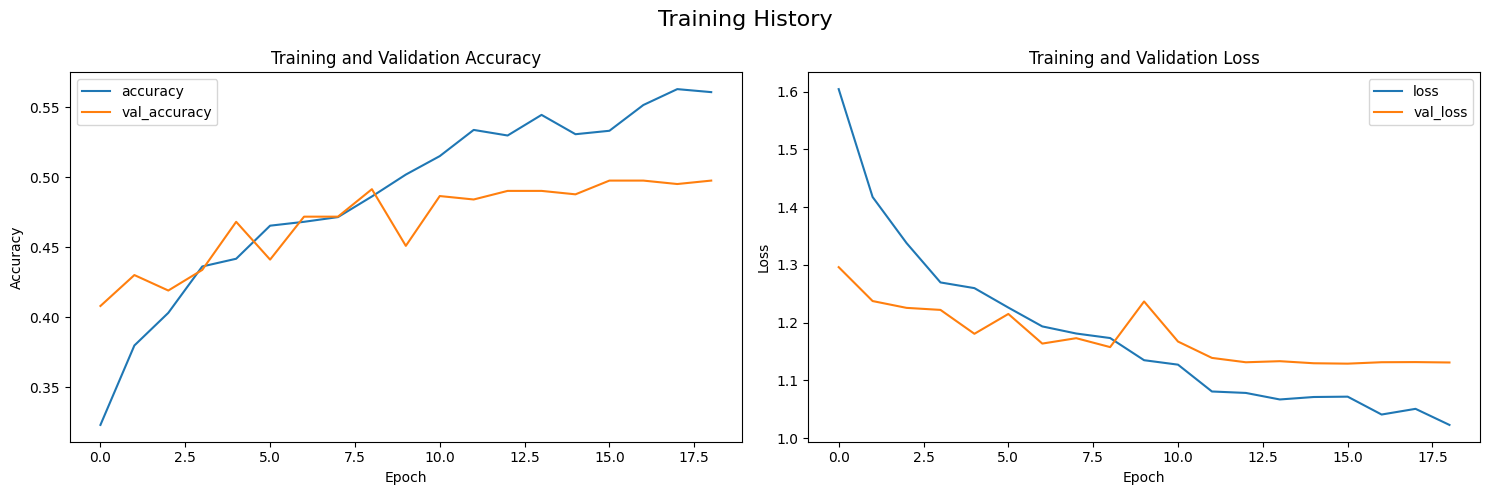

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Training History", fontsize=16)

loaded_history[['accuracy', 'val_accuracy']].plot(ax=axes[0])
axes[0].set_title("Training and Validation Accuracy")
axes[0].set(xlabel="Epoch", ylabel="Accuracy")

loaded_history[['loss', 'val_loss']].plot(ax=axes[1])
axes[1].set_title("Training and Validation Loss")
axes[1].set(xlabel="Epoch", ylabel="Loss")

plt.tight_layout()
plt.show()

## Evaluation on Test Set

In [67]:
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
    
# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')  

16/16 [==============================] - 18s 938ms/step - loss: 1.2111 - accuracy: 0.4451
Test Accuracy: 44.51%
Test Loss: 1.2110536098480225


## Confusion Matrix

In [68]:
# Generate predictions
predictions = loaded_model.predict(test_ds)

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Identify correct and incorrect predictions
correct_predictions = np.where(predicted_labels == true_labels)[0]
incorrect_predictions = np.where(predicted_labels != true_labels)[0]

16/16 [==============================] - 17s 955ms/step


Confusion Matrix


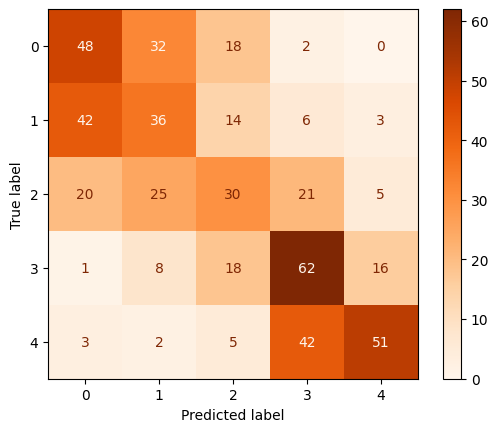

In [69]:
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix')
target_names = ['0', '1', '2', '3', '4']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Oranges)
plt.show()

## Examples of Misclassified Images

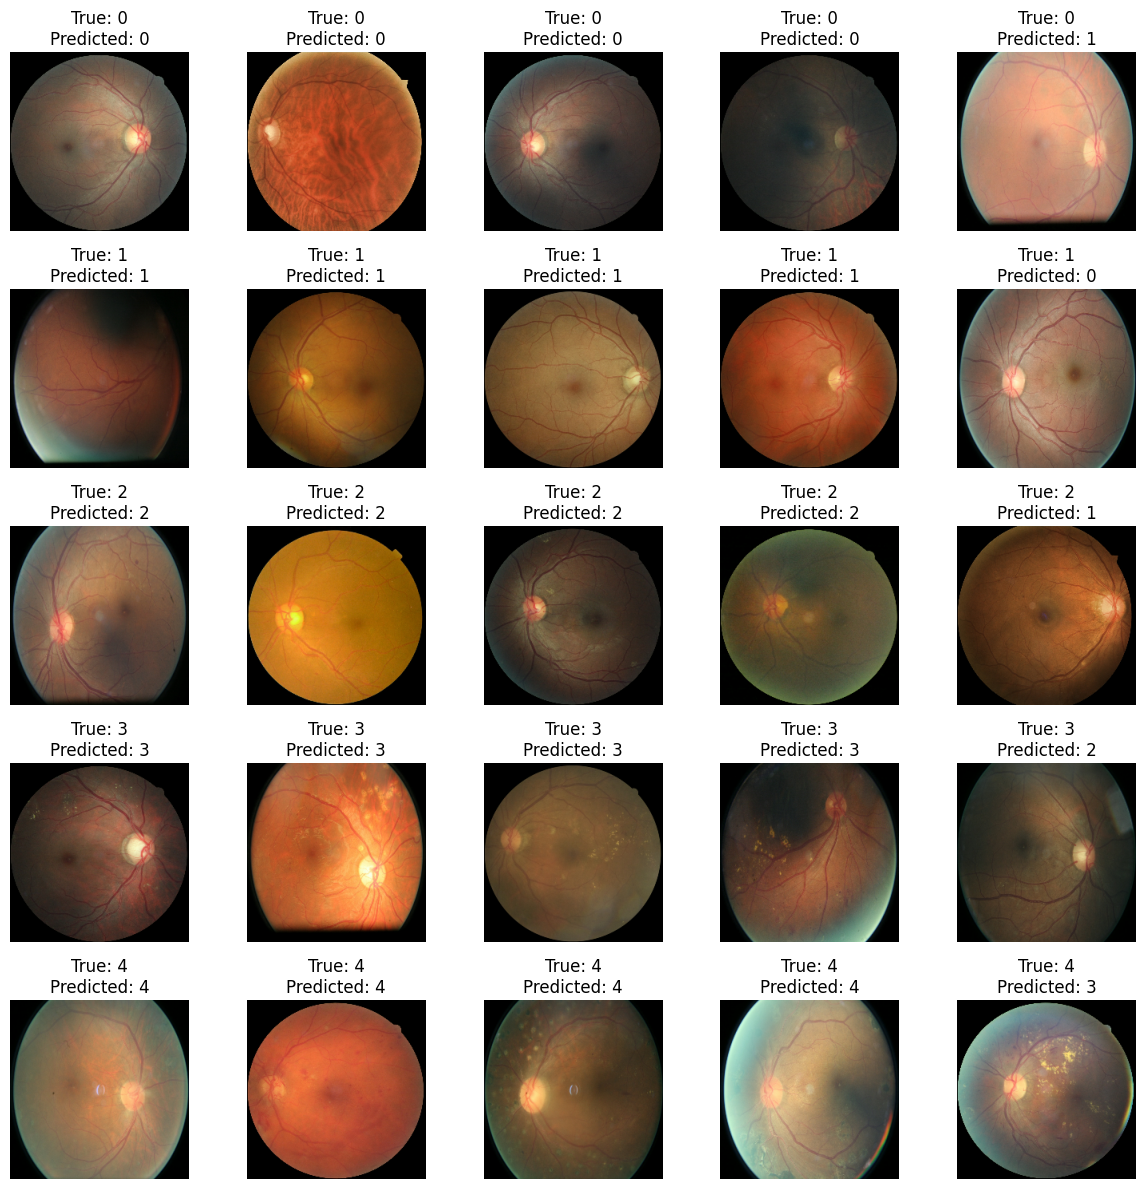

In [58]:
def display_classwise_examples(images, true_labels, predicted_labels, title, num_classes=5):
    classes = np.unique(true_labels)
    
    plt.figure(figsize=(12, 12))
    
    for class_id in classes:
        correct_indices = np.where((true_labels == class_id) & (predicted_labels == class_id))[0]
        incorrect_indices = np.where((true_labels == class_id) & (predicted_labels != class_id))[0]
        
        # Display four correctly classified images
        for i in range(min(4, len(correct_indices))):
            plt.subplot(num_classes, 5, class_id * 5 + i + 1)
            plt.imshow(images[correct_indices[i]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[correct_indices[i]]}', fontsize=12)
            plt.axis('off')

        # Display one incorrectly classified image
        if len(incorrect_indices) > 0:
            plt.subplot(num_classes, 5, class_id * 5 + 5)
            plt.imshow(images[incorrect_indices[0]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[incorrect_indices[0]]}', fontsize=12)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display class-wise examples
display_classwise_examples(
    [image for image, _ in test_ds.unbatch()],
    true_labels,
    predicted_labels,
    title='Class-wise Examples'
)

### Possible Reasons for Misclassification 

|Class|Predicted Class|Possible Reason|
|:-----:|:------:|----|
|0|1|ufghjköölhgkhjlö|
|1|0|hsdfskjhdjf|
|2|0|puiz9uoipü+|
|3|4|puiz9uoipü+|
|4|3|puiz9uoipü+|

## Attention Map

In [59]:
#last_conv_layer_name = "block7a_project_conv"
last_conv_layer_name = "top_conv"

#Paths to one sample image per class 
samples = [
    "../DR_data_cropped_classes/test/0/102_right.jpeg",
    "../DR_data_cropped_classes/test/1/2430_left.jpeg",
    "../DR_data_cropped_classes/test/2/1034_left.jpeg",
    "../DR_data_cropped_classes/test/3/1639_left.jpeg",
    "../DR_data_cropped_classes/test/4/2496_left.jpeg"
]

### Grad-CAM algorithm
https://keras.io/examples/vision/grad_cam/ <br>
https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89

In [60]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [61]:
def save_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img

1/1 [==============================] - 2s 2s/step
True class: 0 - Predicted class: 0
1/1 [==============================] - 0s 59ms/step
True class: 1 - Predicted class: 0
1/1 [==============================] - 0s 58ms/step
True class: 2 - Predicted class: 3
1/1 [==============================] - 0s 59ms/step
True class: 3 - Predicted class: 3
1/1 [==============================] - 0s 62ms/step
True class: 4 - Predicted class: 3


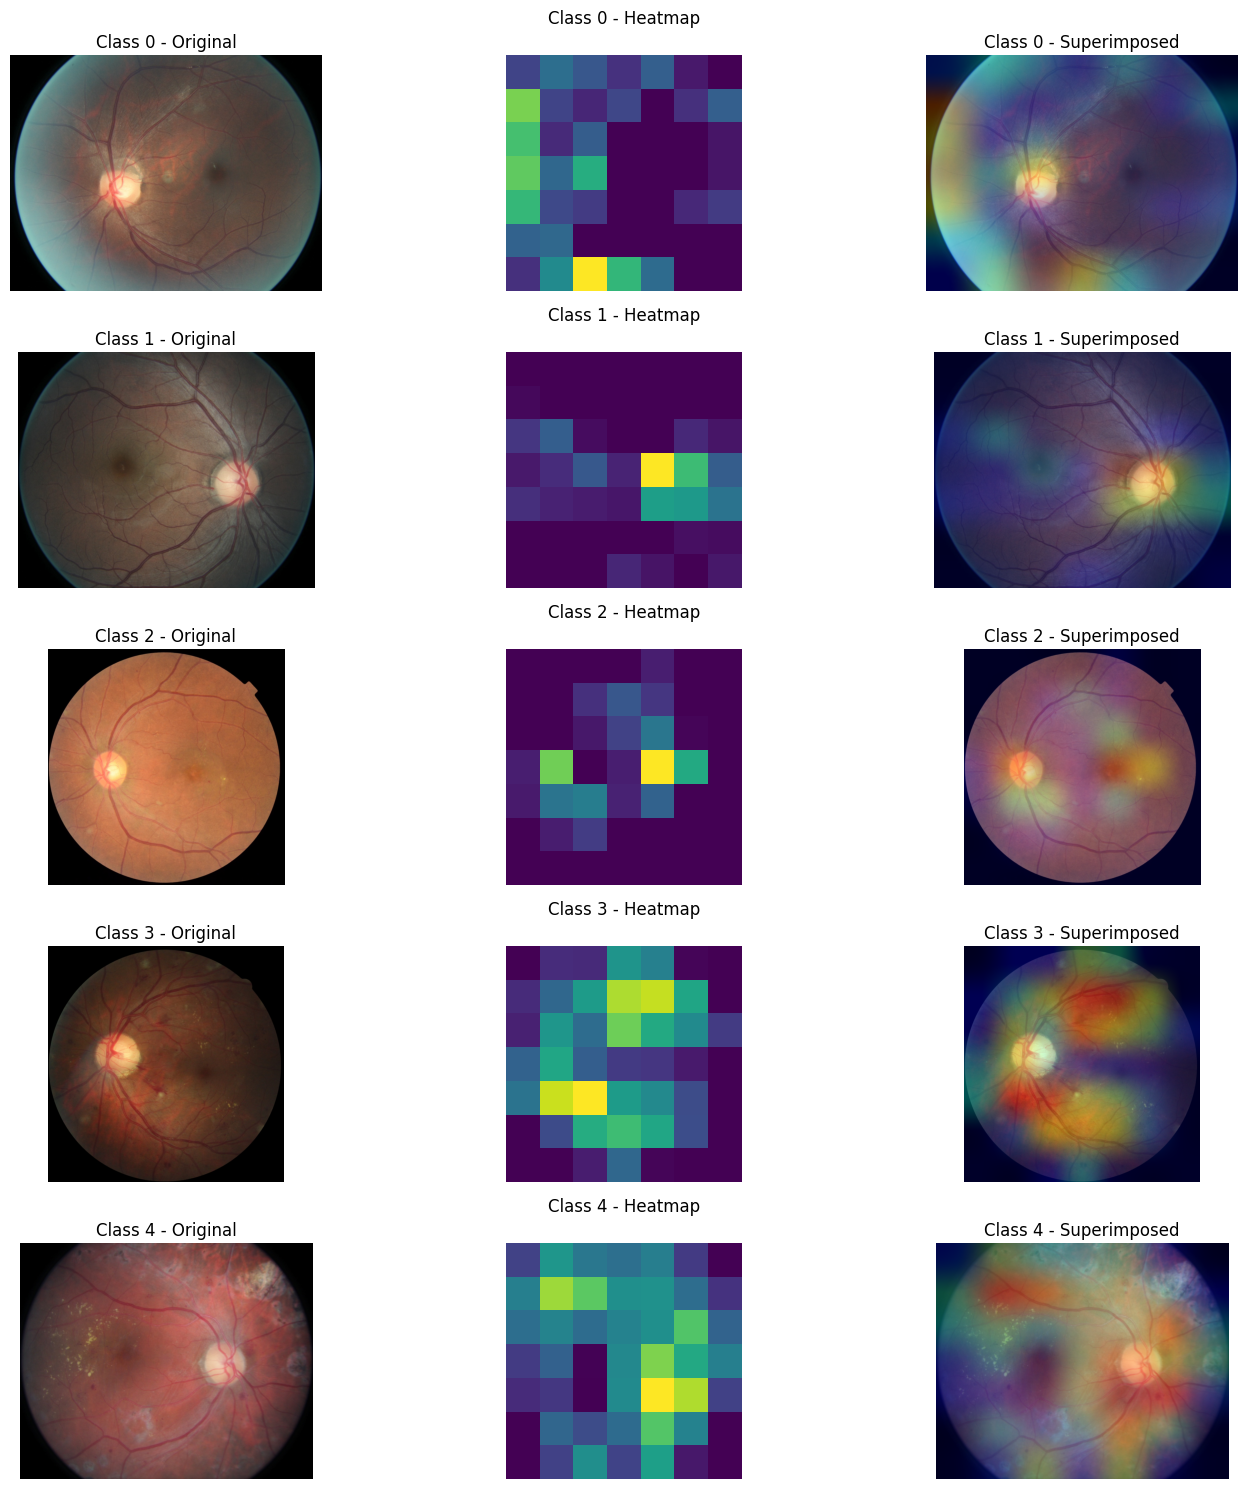

In [62]:
# Create a 2x5 grid for each sample
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i, sample_path in enumerate(samples):
    
    # Prepare image
    img_array = get_img_array(sample_path, size=img_size)

    # Print the predicted class
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    print(f"True class: {i} - Predicted class: {predicted_class}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superimpose the heatmap on the image
    superimposed = save_gradcam(sample_path, heatmap, f"heatmaps/cam{i}.jpg")

    # Display the heatmap on the left and the superimposed image on the right
    axs[i, 0].imshow(load_img(sample_path))
    axs[i, 0].set_title(f"Class {i} - Original")
    axs[i, 0].axis('off')
    
    axs[i, 1].matshow(heatmap)
    axs[i, 1].set_title(f"Class {i} - Heatmap")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(superimposed)
    axs[i, 2].set_title(f"Class {i} - Superimposed")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

### Discussion of Focus on Right Features

|Class|Predicted Class|Focus on right features?|
|:-----:|:------:|----|
|0|1|ufghjköölhgkhjlö|
|1|0|hsdfskjhdjf|
|2|0|puiz9uoipü+|
|3|4|puiz9uoipü+|
|4|3|puiz9uoipü+|